# Module-8 Assignment#1: Dogs vs. Cats Redux: Kaggle
1. Conduct your analysis using a cross-validation design.
2. Conduct EDA.
3. Build at least three CNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Build ROC and Precision / Recall graphs.
6. Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name and screen snapshots of your scores.
7. Discuss your model’s performance.

In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [4]:
!pip install plot_model
!pip install keras

#1. Import Libraries

In [113]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential  # initial NN
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, InputLayer, BatchNormalization # construct each layer
from tensorflow.keras.layers import Conv2D # swipe across the image by 1
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D # swipe across by pool size
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error,sparse_categorical_crossentropy

import pandas as pd
import numpy as np
from random import shuffle
import os
import cv2
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
from tqdm.notebook import trange,tqdm
from IPython.display import Image, display, Markdown, clear_output

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from skimage import io

You are using TensorFlow version 2.7.0
You have a GPU enabled.


In [5]:
# import cv2
# from keras import layers
# from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
# from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
# from keras.models import Model
# from keras.preprocessing import image
# from keras.utils import layer_utils
# from keras.utils.data_utils import get_file
# from keras.applications.imagenet_utils import preprocess_input
# import pydot
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# #from keras.utils import plot_model
# #from keras.utils import to_categorical
# import matplotlib.pyplot as plt 
# from random import shuffle
# np.set_printoptions(suppress=True)
#np.set_printoptions(threshold=np.inf)

In [114]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [115]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [116]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/nw_msdsp/nwds_fall_2021/422_Practical Machine Learning/mod8_TF_CNN/cats_dog/train.zip','r') as z:
    z.extractall('.')
    
with zipfile.ZipFile('/content/drive/MyDrive/nw_msdsp/nwds_fall_2021/422_Practical Machine Learning/mod8_TF_CNN/cats_dog/test.zip','r') as z:
    z.extractall('.')


In [117]:
!pwd
!ls -l

/content
total 1471632
drwx------ 6 root root      4096 Nov 27 19:56 drive
drwxr-xr-x 1 root root      4096 Nov 18 14:36 sample_data
-rw-r--r-- 1 root root     88903 Nov 27 21:09 submission_27nov21_v4.csv
drwxr-xr-x 2 root root    278528 Nov 27 19:57 test
-rw-r--r-- 1 root root 752899775 Nov 27 21:05 Test_Data.npy
drwxr-xr-x 2 root root    761856 Nov 27 19:57 train
-rw-r--r-- 1 root root 752899775 Nov 27 19:59 Training_Data.npy


#2 EDA

In [118]:
# Create image 
IMG_SIZE = 100
X_Train_orig = []
Y_Train_orig = []
for i in os.listdir('/content/train/'):
    label = i.split('.')[-3]
    if label == 'cat':
        label = 0
    elif label == 'dog':
        label = 1
    img = cv2.imread('/content/train/'+i, cv2.IMREAD_COLOR)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    #img = img / 255
    X_Train_orig.append([np.array(img), np.array(label)])

np.save('Training_Data.npy', X_Train_orig)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [119]:
shuffle(X_Train_orig)

In [120]:
X = np.array([i[0] for i in X_Train_orig]).reshape(-1,IMG_SIZE,IMG_SIZE,3)
y = np.array([i[1] for i in X_Train_orig])

In [20]:
print(X)

[[[[248 250 250]
   [238 240 241]
   [240 242 243]
   ...
   [210 222 226]
   [209 221 225]
   [208 220 224]]

  [[247 249 249]
   [238 240 241]
   [239 241 242]
   ...
   [212 224 228]
   [205 217 221]
   [208 220 224]]

  [[248 250 250]
   [240 242 243]
   [245 247 248]
   ...
   [210 222 226]
   [208 220 224]
   [208 220 224]]

  ...

  [[ 60  36  41]
   [ 76  50  56]
   [102 110 110]
   ...
   [188 194 201]
   [168 179 190]
   [157 173 187]]

  [[ 37  62  60]
   [153 160 160]
   [215 240 237]
   ...
   [199 222 224]
   [208 231 233]
   [201 225 226]]

  [[225 238 240]
   [222 232 236]
   [217 224 232]
   ...
   [212 224 230]
   [174 185 193]
   [200 209 222]]]


 [[[210 197 199]
   [211 198 200]
   [212 199 201]
   ...
   [ 48  41  38]
   [ 48  41  38]
   [ 50  43  40]]

  [[206 193 195]
   [208 195 197]
   [206 193 195]
   ...
   [ 48  41  38]
   [ 50  43  40]
   [ 51  44  41]]

  [[205 192 194]
   [206 193 195]
   [208 195 197]
   ...
   [ 49  42  39]
   [ 51  44  41]
   [ 54  47

In [21]:
print(y)

[0 1 1 ... 0 0 1]


In [121]:
print("Shape of X is: ",X.shape)
print("Shape of y is: ",y.shape)

Shape of X is:  (25000, 100, 100, 3)
Shape of y is:  (25000,)


In [122]:
# Spilt Training and test data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, stratify=y)

In [124]:
print('Shape of X_train is :', X_train.shape)
print('Shape of y_train is :', y_train.shape)
print('Shape of X_val is :', X_val.shape)
print('Shape of y_val is :', y_val.shape)

Shape of X_train is : (20000, 100, 100, 3)
Shape of y_train is : (20000,)
Shape of X_val is : (5000, 100, 100, 3)
Shape of y_val is : (5000,)


In [125]:
print(pd.Series(y_train).value_counts(1))
print(pd.Series(y_val).value_counts(1))

1    0.5
0    0.5
dtype: float64
1    0.5
0    0.5
dtype: float64


In [21]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.25, stratify=Y_train)

In [32]:
# print('Shape of X_train is :', X_train.shape)
# print('Shape of Y_train is :', Y_train.shape)
# print('Shape of X_val is :', X_val.shape)
# print('Shape of Y_val is :', Y_val.shape)

In [33]:
# print(pd.Series(Y_train).value_counts(1))
# print(pd.Series(Y_val).value_counts(1))

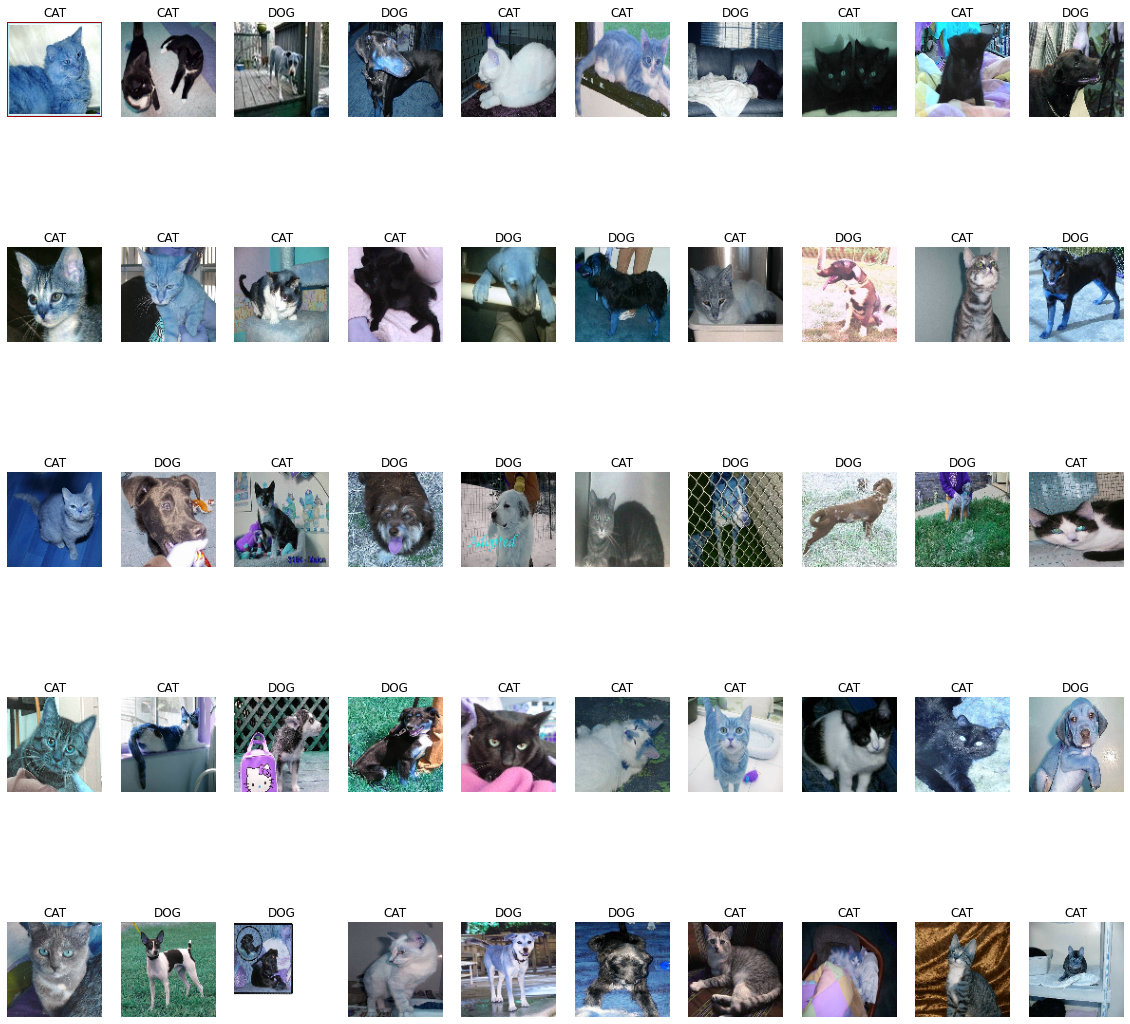

In [126]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,20))   # to fix a shape for each image print
for i in range(50):          # using a for loop to display a number of images
    plt.subplot(5, 10, i+1) # we need to use this function to print an array of pictures 
    plt.imshow(X_val[i,:,:,:]) # this will call the images from train set one by one
    plt.title('DOG' if y_val[i] == 1 else 'CAT')  # Lets also look into the labels 
    plt.axis('off') 

#3 CNN Model Development and Training

In [127]:
def cnn_model(input_shape):    
    
    X_input = Input(input_shape)

    X = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', name = 'conv1')(X_input) 
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X) 
    
    X = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', name = 'conv2')(X_input) 
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X) 

    X = MaxPooling2D((3, 3), name='max_pool_0')(X)
    X = Dropout(0.3)(X)

    X = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same', name = 'conv3')(X) 
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same', name = 'conv4')(X) 
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same', name = 'conv5')(X) 
    X = BatchNormalization(axis = 3, name = 'bn5')(X)
    X = Activation('relu')(X)
   
    X = MaxPooling2D((3, 3), name='max_pool_1')(X)
    X = Dropout(0.3)(X)
    
    # Flatten the data.
    X = Flatten()(X)
    # Dense Layer
    X = Dense(4096, activation='relu', name='fc1')(X)
    X = Dropout(0.1)(X)
    X = Dense(1024, activation='relu', name='fc2')(X)
    X = Dropout(0.1)(X)
    X = Dense(256, activation='relu', name='fc3')(X)
    # Using softmax function to get the output
    X = Dense(1, activation='sigmoid', name='fc4')(X)
    
    model = Model(inputs = X_input, outputs = X, name='model')
    
    return model

In [128]:
cnn_model = cnn_model(X_train.shape[1:4])

In [129]:
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
epochs = 100
batch_size = 64
learning_rate = 0.001
decay = learning_rate/epochs
optimizer = Adam(learning_rate=learning_rate, epsilon=1e-08, decay = decay)

In [130]:
cnn_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [131]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=1, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [132]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, restore_best_weights=True, mode='auto')

In [133]:
cnn_history = cnn_model.fit(x = X_train, y = y_train, batch_size = batch_size, 
                        epochs=epochs, verbose=1, 
                        validation_data = (X_val, y_val),
                          shuffle = True, 
                          steps_per_epoch= None, validation_steps=None,
                                  callbacks=[learning_rate_reduction, early_stopping] )

Epoch 1/100
313/313 [==============================] - 14s 43ms/step - loss: 1.6696 - accuracy: 0.5752 - val_loss: 0.6499 - val_accuracy: 0.6278 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5901 - accuracy: 0.6794 - val_loss: 0.5633 - val_accuracy: 0.7024 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5321 - accuracy: 0.7304 - val_loss: 0.6093 - val_accuracy: 0.6838 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 13s 41ms/step - loss: 0.4976 - accuracy: 0.7577 - val_loss: 0.8356 - val_accuracy: 0.5568 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4615 - accuracy: 0.7819 - val_loss: 0.6179 - val_accuracy: 0.6942 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.4367 - accuracy: 0.7975 - val_loss: 0.4782 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 7/100
313/313 [==============================]

In [134]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

## 4. Model Performance

In [135]:
preds = Keras_Model.evaluate(X_train, y_train)
print ("Loss = " + str(preds[0]))
print ("Train set Accuracy = " + str(preds[1]))

625/625 [==============================] - 4s 7ms/step - loss: 0.1893 - accuracy: 0.9481
Loss = 0.18930073082447052
Train set Accuracy = 0.9480500221252441


In [136]:
preds_val = Keras_Model.evaluate(X_val, y_val)
print ("Loss = " + str(preds_val[0]))
print ("Validation Set Accuracy = " + str(preds_val[1]))

157/157 [==============================] - 1s 8ms/step - loss: 0.1928 - accuracy: 0.9474
Loss = 0.19278912246227264
Validation Set Accuracy = 0.9473999738693237


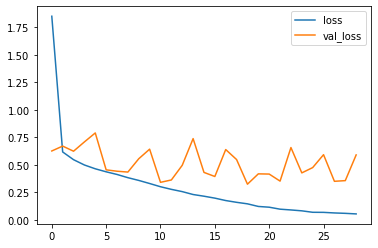

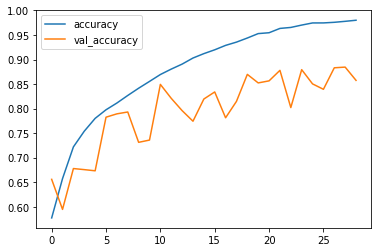

In [137]:
history_df = pd. DataFrame(history.history)
history_df.loc[:,['loss', 'val_loss']].plot()
history_df.loc[:,['accuracy', 'val_accuracy']].plot()

In [138]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [139]:
val_loss = history_dict['val_loss']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
acc = history_dict['accuracy']
epochs = range(1,len(history_dict['val_loss'])+1)

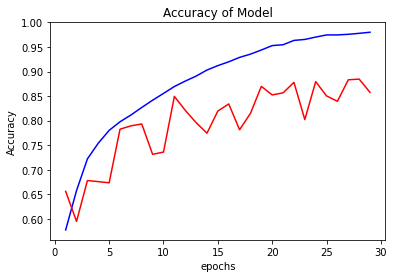

In [140]:
plt.plot(epochs,acc,'b-')
plt.title('Accuracy of Model')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.plot(epochs,val_acc,'b-', color = 'red')
plt.title('Accuracy of Model')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.show()

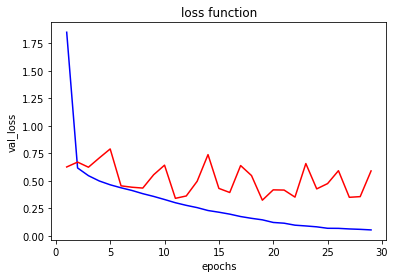

In [141]:
plt.plot(epochs,loss,'b-')
plt.title('loss function')
plt.xlabel('epochs')
plt.ylabel('Loss')

plt.plot(epochs,val_loss,'b-', color = 'red')
plt.title('loss function')
plt.xlabel('epochs')
plt.ylabel('val_loss')
plt.show()

##5 Model Prediction and Kaggle submission

In [142]:
predicted_val_probability = cnn_model.predict(X_val, batch_size=64)

In [144]:
y_val_pred_label = np.round(predicted_val_probability)
l = []
for i in range(len(y_val_pred_label)):
    if y_val[i] != y_val_pred_label[i]:
        l.append(i)

In [145]:
m = []
for t in l:
    if predicted_val_probability[t] >= 0.5:
        m.append(t)
    elif predicted_val_probability[t] < 0.5:
        m.append(t)
    

In [146]:
predicted_val_probability[predicted_val_probability >= 0.5] = 1
predicted_val_probability[predicted_val_probability < 0.5] = 0

In [147]:
predicted_val_probability.flatten()

array([0., 0., 1., ..., 1., 0., 0.], dtype=float32)

In [98]:
len(predicted_val_probability)

5000

ValueError: ignored

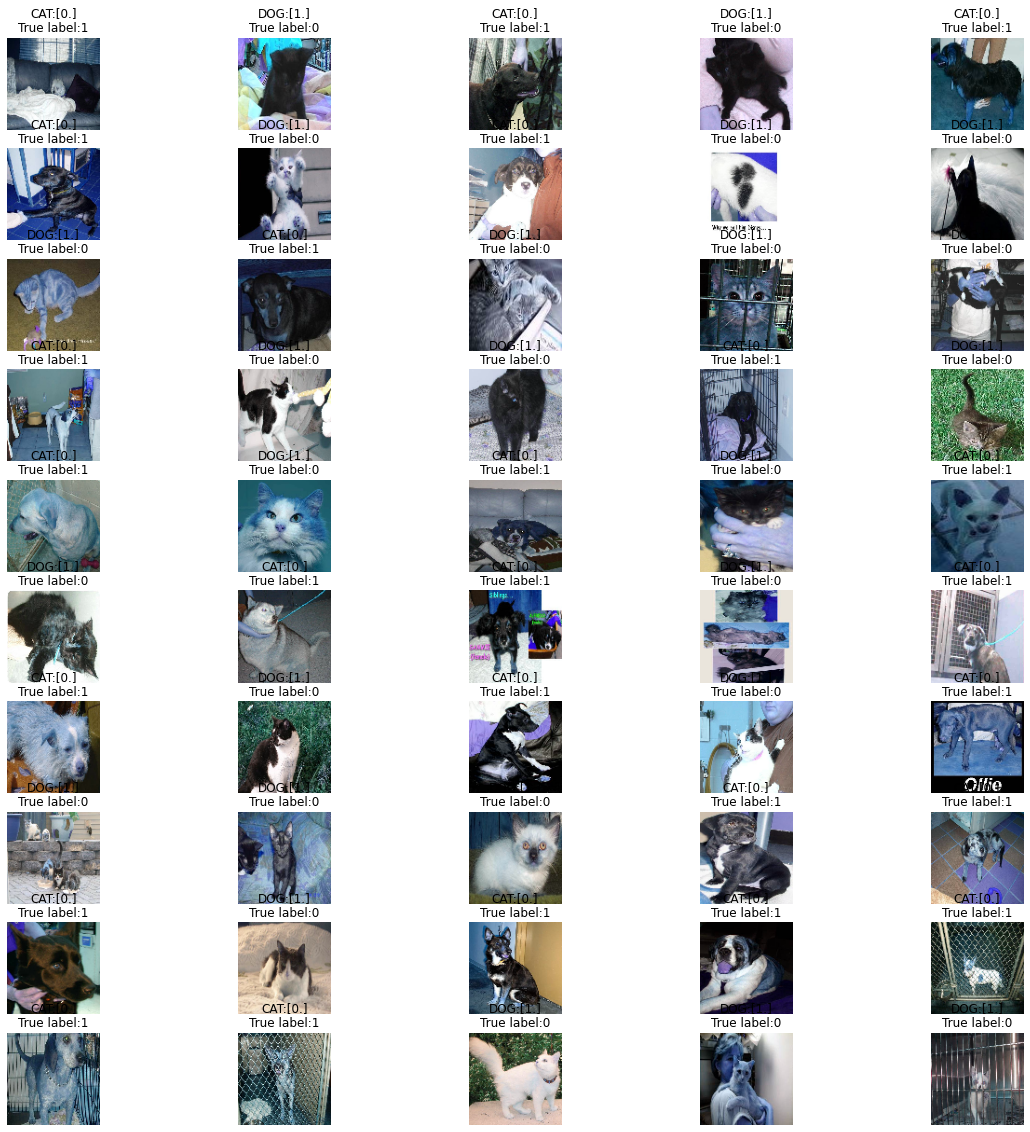

In [148]:
plt.figure(figsize=(20,20))
c = 1
for i in m[:]:
    plt.subplot(10,5,c)
    plt.imshow(X_val[i])
    plt.title('DOG:{}\nTrue label:{}'.format(predicted_val_probability[i], y_val[i])
              if predicted_val_probability[i]>= 0.5 else 'CAT:{}\nTrue label:{}'.format(predicted_val_probability[i],y_val[i]))
    plt.axis('off')
    c = c+1

In [149]:
X_Test_orig = []
for i in os.listdir('/content/test/'):
    label = i.split('.')[-2]
    img = cv2.imread('/content/test/'+i, cv2.IMREAD_COLOR)
    img = cv2.resize(img,(IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_CUBIC)
    #img = img / 255
    X_Test_orig.append([np.array(img), np.array(label)])

np.save('Test_Data.npy', X_Train_orig)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [150]:
X_test = np.array([i[0] for i in X_Test_orig]).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
Label = np.array([i[1] for i in X_Test_orig])

In [151]:
X_test = X_test / 255

In [152]:
classes = cnn_model.predict(X_test, batch_size = batch_size), 
classes

(array([[0.00589771],
        [0.00610024],
        [0.00622129],
        ...,
        [0.00582597],
        [0.00610031],
        [0.00672972]], dtype=float32),)

In [153]:
prediction = pd.DataFrame()
prediction['id'] = Label
prediction['label'] = classes[0].flatten()
prediction.loc[prediction['label'] >= 0.5, 'label'] = 1
prediction.loc[prediction['label'] < 0.5, 'label'] = 0
prediction['label'] = prediction['label'].astype(int)
prediction.sort_values(by='id', inplace=True)

prediction.to_csv('submission_27nov21_v5.csv', index = False)